In [1]:
from pathlib import Path

# set BIDS root directory
bids_root = Path(
    "/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main"
)

sub = "sub-01"

# find sessions
sessions = sorted([p.name for p in (bids_root / sub).glob("ses-*")])
print("Found sessions:", sessions)

ieeg_edfs = []
events_tsvs = []

for ses in sessions:
    ses_dir = bids_root / sub / ses 

    edf = next(ses_dir.glob(f"{sub}_{ses}_task-verbalWM*_ieeg.edf"))
    ev  = next(ses_dir.glob(f"{sub}_{ses}_task-verbalWM*_events.tsv"))

    ieeg_edfs.append(edf)
    events_tsvs.append(ev)

# check
for a, b in zip(ieeg_edfs, events_tsvs):
    print(a)
    print(b)

Found sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04']
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-01/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-01/sub-01_ses-01_task-verbalWM_run-01_events.tsv
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-02/sub-01_ses-02_task-verbalWM_run-01_ieeg.edf
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-02/sub-01_ses-02_task-verbalWM_run-01_events.tsv
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-03/sub-01_ses-03_task-verbalWM_run-01_ieeg.edf
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-03/sub-01_ses-03_task-verbalWM_run-01_events.tsv
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-04/sub-01_ses-04_t

In [2]:
import pandas as pd
import mne
mne.set_log_level("ERROR")

edf_path = ieeg_edfs[0]
ev_path  = events_tsvs[0]

raw = mne.io.read_raw_edf(edf_path, preload=True)
events = pd.read_csv(ev_path, sep="\t")

fs = raw.info["sfreq"]
print("sfreq:", fs)
print("events columns:", list(events.columns))
print(events[["SetSize"]].value_counts().sort_index())

# --- separate trials by difficulty ---
easy_trials   = events.index[events["SetSize"] == 4].to_numpy()
medium_trials = events.index[events["SetSize"] == 6].to_numpy()
hard_trials   = events.index[events["SetSize"] == 8].to_numpy()

print("n easy:", len(easy_trials))
print("n medium:", len(medium_trials))
print("n hard:", len(hard_trials))

raw = mne.io.read_raw_edf(edf_path, preload=False)
print("channel number:", len(raw.ch_names))

sfreq: 2000.0
events columns: ['onset', 'duration', 'nTrial', 'begSample', 'endSample', 'SetSize', 'ProbeLetter', 'Match', 'Correct', 'ResponseTime', 'Artifact']
SetSize
4          21
6          12
8          17
Name: count, dtype: int64
n easy: 21
n medium: 12
n hard: 17
channel number: 48


In [3]:
import numpy as np
from scipy.signal import hilbert
from mne.filter import filter_data


def compute_plv_matrix(
    raw,
    low_band,
    high_band,
    start,
    end
):
    # === Compute PLV matrix for all channel pairs ===

    fs = float(raw.info["sfreq"])

    data = raw.get_data()           # shape: (n_channels, n_samples)
    n_channels = data.shape[0]

    # Prepare PLV matrix
    plv_matrix = np.zeros((n_channels, n_channels), dtype=float)

    # Two loops over all channel couples (i,j)
    for i in range(n_channels):
        # Take channel i as the low-frequency phase channel
        ch_lf = data[i, :]

        # ---- low-band filter + Hilbert  ----
        lf_filtered = filter_data(
            ch_lf, sfreq=fs, l_freq=low_band[0], h_freq=low_band[1]
        )
        analytic_lf = hilbert(lf_filtered)
        phase_lf = np.angle(analytic_lf)

        for j in range(n_channels):
            # Take channel j as the high-frequency amplitude channel
            ch_hf = data[j, :]

            # ---- high-band filter + Hilbert ----
            hf_filtered = filter_data(
                ch_hf, sfreq=fs, l_freq=high_band[0], h_freq=high_band[1]
            )
            analytic_hf = hilbert(hf_filtered)
            amp_hf = np.abs(analytic_hf)

            analytic_hf_abs = hilbert(amp_hf)
            phase_hf = np.angle(analytic_hf_abs)

            # ---- PLV (restricted to [start:end]) ----
            phase_diff = phase_lf - phase_hf
            plv_val = np.abs(
                np.mean(np.exp(1j * phase_diff[start:end]))
            )

            # store in matrix
            plv_matrix[i, j] = plv_val

    return plv_matrix

In [ ]:
low_band = (12, 30)
high_band = (70, 250)
n_channels = len(raw.ch_names)

# === Compute PLV matrices for easy vs hard trials ===

plv_easy = np.zeros((n_channels, n_channels))

for t in easy_trials:
    start = int(events.loc[t, "begSample"])
    end   = int(events.loc[t, "endSample"])

    plv_easy += compute_plv_matrix(raw, low_band, high_band, start, end)

plv_easy /= len(easy_trials)

plv_medium = np.zeros((n_channels, n_channels))

for t in medium_trials:
    start = int(events.loc[t, "begSample"])
    end   = int(events.loc[t, "endSample"])

    plv_medium += compute_plv_matrix(
        raw,
        low_band,
        high_band,
        start,
        end
    )

plv_medium /= len(medium_trials)

plv_hard = np.zeros((n_channels, n_channels))
for t in hard_trials:
    start = int(events.loc[t, "begSample"])
    end   = int(events.loc[t, "endSample"])

    plv_hard += compute_plv_matrix(raw, low_band, high_band, start, end)

plv_hard /= len(hard_trials)

In [4]:
# pull results - sub-01

plv_easy = np.load("sub-01_plv_easy.npy")
plv_hard = np.load("sub-01_plv_hard.npy")
plv_medium = np.load("sub-01_plv_medium.npy")

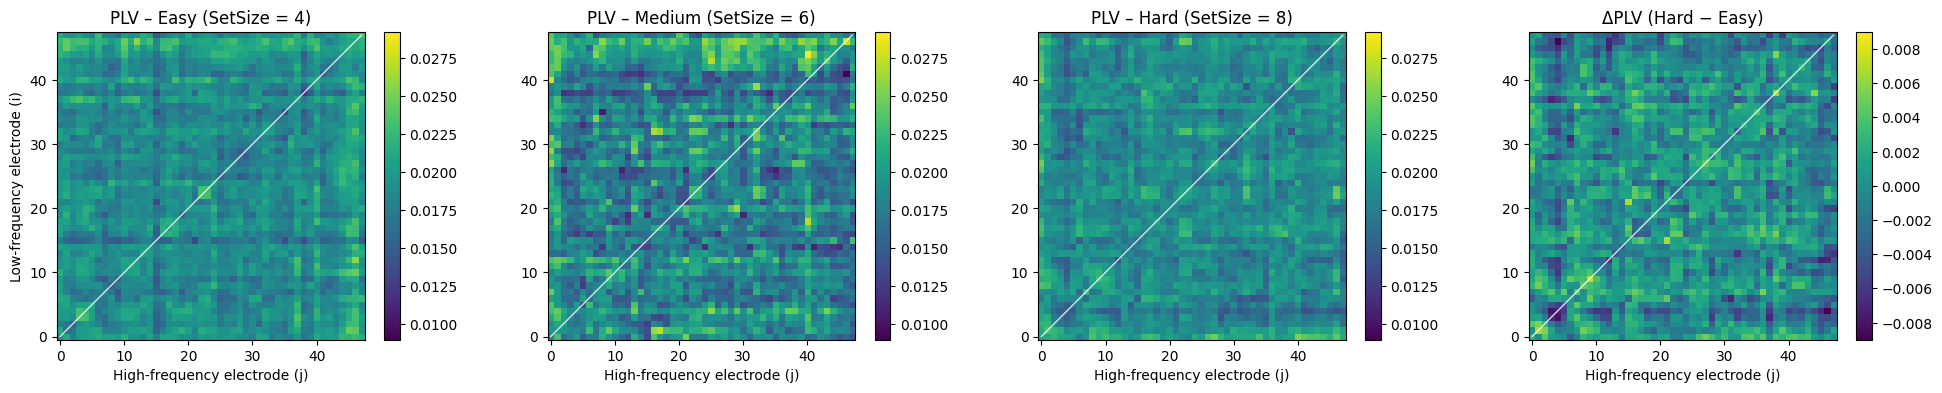

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def draw_symmetry_line(ax, n):
    ax.plot([0, n - 1], [0, n - 1], color="white", linewidth=1, alpha=0.8)

# --- Compute delta ---
plv_delta = plv_hard - plv_easy

n_ch = plv_easy.shape[0]

# --- Shared scale for Easy / Medium / Hard ---
vmin = min(plv_easy.min(), plv_medium.min(), plv_hard.min())
vmax = max(plv_easy.max(), plv_medium.max(), plv_hard.max())

# --- Symmetric scale for Delta ---
delta_max = np.max(np.abs(plv_delta))

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# --- Easy ---
im0 = axes[0].imshow(
    plv_easy,
    origin="lower",
    aspect="equal",
    vmin=vmin,
    vmax=vmax
)
draw_symmetry_line(axes[0], n_ch)
axes[0].set_title("PLV – Easy (SetSize = 4)")
axes[0].set_xlabel("High-frequency electrode (j)")
axes[0].set_ylabel("Low-frequency electrode (i)")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# --- Medium ---
im1 = axes[1].imshow(
    plv_medium,
    origin="lower",
    aspect="equal",
    vmin=vmin,
    vmax=vmax
)
draw_symmetry_line(axes[1], n_ch)
axes[1].set_title("PLV – Medium (SetSize = 6)")
axes[1].set_xlabel("High-frequency electrode (j)")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# --- Hard ---
im2 = axes[2].imshow(
    plv_hard,
    origin="lower",
    aspect="equal",
    vmin=vmin,
    vmax=vmax
)
draw_symmetry_line(axes[2], n_ch)
axes[2].set_title("PLV – Hard (SetSize = 8)")
axes[2].set_xlabel("High-frequency electrode (j)")
plt.colorbar(im2, ax=axes[2], fraction=0.046)

# --- Delta (Hard - Easy) ---
im3 = axes[3].imshow(
    plv_delta,
    origin="lower",
    aspect="equal",
    vmin=-delta_max,
    vmax=delta_max
)
draw_symmetry_line(axes[3], n_ch)
axes[3].set_title("ΔPLV (Hard − Easy)")
axes[3].set_xlabel("High-frequency electrode (j)")
plt.colorbar(im3, ax=axes[3], fraction=0.046)

plt.tight_layout()
plt.show()

In [ ]:
# assure symmetry

assert np.allclose(plv_easy, plv_easy.T, atol=1e-6)
assert np.allclose(plv_hard, plv_hard.T, atol=1e-6)

print(np.max(np.abs(plv_easy - plv_easy.T)))
print(np.max(np.abs(plv_hard - plv_hard.T)))

In [ ]:
# Ask Shir whether to symmetrize the medium matrix, because it had less trials and that produced noiser results

# plv_medium = 0.5 * (plv_medium + plv_medium.T)

Yeo atlas

In [ ]:
from nilearn.datasets import fetch_atlas_yeo_2011

# fetch Yeo 2011 atlas (7 networks), using HTTPS URL
yeo = fetch_atlas_yeo_2011(
    n_networks=7,
    thickness="thick",  # thick mask is usually better for electrode mapping
    url="https://ftp.nmr.mgh.harvard.edu/pub/data/Yeo_JNeurophysiol11_MNI152.zip",
    resume=True,
    verbose=1,
)

print(yeo.keys())
atlas_path = yeo["maps"]
print("atlas_path:", atlas_path)

[fetch_atlas_yeo_2011] Dataset found in /Users/ohadgonen/nilearn_data/yeo_2011
dict_keys(['maps', 'labels', 'description', 'lut', 'atlas_type', 'template', 'anat'])
atlas_path: /Users/ohadgonen/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz


In [ ]:
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.spatial import cKDTree

'''
Yeo7 atlas mapping function.
'''

YEO7_LABELS = {
    0: "Unlabeled",
    1: "Visual",
    2: "Somatomotor",
    3: "Dorsal Attention",
    4: "Ventral Attention / Salience (CON)",
    5: "Limbic",
    6: "Frontoparietal (FPN)",
    7: "Default Mode (DMN)",
}

def mode_int(x: np.ndarray) -> int:
    """Most frequent integer in x (ties -> first by np.argmax)."""
    if x.size == 0:
        return 0
    vals, counts = np.unique(x.astype(int), return_counts=True)
    return int(vals[np.argmax(counts)])

def map_electrodes_to_yeo7(
    chan_names: list[str],
    mni_xyz_mm: np.ndarray,          # (N,3) electrode coords in MNI mm
    atlas_nii_path: str,             # Yeo atlas nifti
    range_mm: float = 10.0,          # MATLAB: range = 10 (mm)
) -> pd.DataFrame:

    # --- inputs ---
    mni_xyz_mm = np.asarray(mni_xyz_mm, dtype=float)
    if mni_xyz_mm.ndim != 2 or mni_xyz_mm.shape[1] != 3:
        raise ValueError("mni_xyz_mm must be (N,3)")
    if len(chan_names) != mni_xyz_mm.shape[0]:
        raise ValueError("chan_names and mni_xyz_mm length mismatch")

    # --- load atlas ---
    img = nib.load(atlas_nii_path)
    data = np.asarray(img.get_fdata())
    affine = np.asarray(img.affine)

    # atlas can be (X,Y,Z,1) -> squeeze to (X,Y,Z)
    if data.ndim == 4:
        data = np.squeeze(data)
    if data.ndim != 3:
        raise ValueError(f"Expected 3D atlas, got shape {data.shape}")

    data = data.astype(int)
    if affine.shape != (4, 4):
        affine = affine[:4, :4]

    # --- build labeled-voxel point cloud (voxel ijk -> MNI xyz mm) ---
    # ijk: indices of voxels where label>0 ; labels: corresponding label at each ijk
    ijk = np.column_stack(np.where(data > 0))          # (n_vox, 3)
    labels = data[data > 0].astype(int)                # (n_vox,)

    xyz = nib.affines.apply_affine(affine, ijk)        # (n_vox, 3) in MNI mm

    # KD-tree speeds up radius queries (equivalent to MATLAB dist computation)
    tree = cKDTree(xyz)

    out_label = np.zeros(len(chan_names), dtype=int)
    out_min_dist = np.zeros(len(chan_names), dtype=float)

    for i, elec_xyz in enumerate(mni_xyz_mm):
        # MATLAB: min(dist)
        min_dist, nn_idx = tree.query(elec_xyz, k=1)
        out_min_dist[i] = float(min_dist)

        # MATLAB: labels_within = labels(dist > min_dist & dist < min_dist + range)
        r = float(min_dist + range_mm)
        cand = tree.query_ball_point(elec_xyz, r=r)    # includes dist <= r

        if len(cand) == 0:
            out_label[i] = 0
            continue

        cand = np.asarray(cand, dtype=int)

        # inequality filtering
        d = np.linalg.norm(xyz[cand] - elec_xyz[None, :], axis=1)
        keep = (d > min_dist) & (d < (min_dist + range_mm))

        if not np.any(keep):
            out_label[i] = 0
            continue

        out_label[i] = mode_int(labels[cand[keep]])
    
    df = pd.DataFrame({
        "channel": list(chan_names),
        "x": mni_xyz_mm[:, 0],
        "y": mni_xyz_mm[:, 1],
        "z": mni_xyz_mm[:, 2],
        "min_dist_mm": out_min_dist,
        "yeo7_label": out_label,
        "yeo7_network": [YEO7_LABELS.get(int(l), "Unknown") for l in out_label],
    })

    return df


In [ ]:
import numpy as np
import pandas as pd

# Load electrodes TSV (BIDS electrodes.tsv)
tsv_path = "/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/sub-01_ses-01_task-verbalWM_run-01_electrodes.tsv"
elec = pd.read_csv(tsv_path, sep="\t")

# Identify name + coordinate columns
name_col = "name" if "name" in elec.columns else "channel"  # fallback
x_col, y_col, z_col = "x", "y", "z"

assert name_col in elec.columns, f"Couldn't find electrode name column. Have: {elec.columns}"
assert all(c in elec.columns for c in [x_col, y_col, z_col]), f"Need x,y,z columns. Have: {elec.columns}"

# Clean names for matching
def _clean(s: str) -> str:
    return str(s).strip()

elec[name_col] = elec[name_col].map(_clean)

raw_names = [_clean(ch) for ch in raw.ch_names]

# Create lookup table by name
elec_idx = elec.set_index(name_col)

# Make sure every raw channel exists in TSV (or show what's missing)
missing = [ch for ch in raw_names if ch not in elec_idx.index]
if missing:
    print("Channels in raw missing from TSV (first 20):", missing[:20])
    raise ValueError(
        f"{len(missing)} channels from raw.ch_names were not found in electrodes.tsv. "
        "Usually this is a naming mismatch (prefix/suffix/case)."
    )

# Build mni_xyz_mm in  raw order
mni_xyz_mm = elec_idx.loc[raw_names, [x_col, y_col, z_col]].to_numpy(dtype=float)

# Map to Yeo networks
df_map = map_electrodes_to_yeo7(
    chan_names=raw.ch_names,
    mni_xyz_mm=mni_xyz_mm,
    atlas_nii_path=atlas_path,   
    range_mm=10.0,
)


chan_to_net = dict(zip(df_map["channel"], df_map["yeo7_network"]))

df_map

[[-25.19908493 -12.87539213 -14.7916941 ]
 [-30.48709749 -12.12159308 -14.9700458 ]
 [-36.70354941 -11.76907063 -16.07609998]
 [-41.89686362 -10.39534986 -17.07094397]
 [-47.16101747  -9.48198513 -18.04398207]
 [-52.35912683  -8.2081408  -18.03750256]
 [-58.09813801  -7.81378664 -19.11058641]
 [-64.54943595  -5.88163811 -19.77911181]
 [-21.93290156  -5.36251156 -17.53302816]
 [-27.67736756  -5.377454   -16.50550346]
 [-33.38845796  -5.23756895 -16.3572359 ]
 [-39.16880541  -5.73341717 -15.41240798]
 [-44.47474396  -5.12201004 -15.20159064]
 [-50.15588033  -5.11854576 -14.19268333]
 [-55.92791212  -5.01696052 -13.93846876]
 [-61.17363213  -5.55402689 -12.80394161]
 [-24.29368577  -1.66405359 -25.75740882]
 [-29.3652724    0.80336792 -26.68349542]
 [-34.48210741   2.35907797 -27.71761866]
 [-40.07952652   3.88688029 -28.68593609]
 [-44.7630505    5.75707992 -28.71413701]
 [-50.37199487   7.28369939 -29.58985438]
 [-55.90319226   8.82016571 -31.06083096]
 [-59.87150645   9.60833283 -31.11

,channel,x,y,z,min_dist_mm,yeo7_label,yeo7_network
0,mAHL1,-25.199085,-12.875392,-14.791694,9.787659,5,Limbic
1,mAHL2,-30.487097,-12.121593,-14.970046,7.117199,4,Ventral Attention / Salience (CON)
2,mAHL3,-36.703549,-11.769071,-16.076100,3.565598,4,Ventral Attention / Salience (CON)
3,mAHL4,-41.896864,-10.395350,-17.070944,2.653333,4,Ventral Attention / Salience (CON)
4,mAHL5,-47.161017,-9.481985,-18.043982,0.968574,7,Default Mode (DMN)
5,mAHL6,-52.359127,-8.208141,-18.037503,0.416775,7,Default Mode (DMN)
6,mAHL7,-58.098138,-7.813787,-19.110586,0.237773,7,Default Mode (DMN)
7,mAHL8,-64.549436,-5.881638,-19.779112,0.515567,7,Default Mode (DMN)
8,mAL1,-21.932902,-5.362512,-17.533028,6.887511,5,Limbic
9,mAL2,-27.677368,-5.377454,-16.505503,7.877498,5,Limbic


In [38]:
import numpy as np
import pandas as pd

def intranetwork_connectivity(
    plv_by_condition: dict[str, np.ndarray],
    df_map: pd.DataFrame,
    chan_order: list[str],
    drop_unlabeled: bool = True,
    symmetrize: bool = True,
) -> pd.DataFrame:
    """
    Compute intra-network mean PLV for each Yeo7 network in each condition.

    Parameters
    ----------
    plv_by_condition : dict
        e.g. {"easy": plv_easy, "medium": plv_medium, "hard": plv_hard}
    df_map : pd.DataFrame
        Output of map_electrodes_to_yeo7. Must include columns: ["channel","yeo7_network"].
    chan_order : list[str]
        Channel order that matches the PLV matrices (usually raw.ch_names).
    drop_unlabeled : bool
        If True, exclude electrodes mapped to "Unlabeled".
    symmetrize : bool
        If True, use 0.5*(M+M.T) before summarizing (treat PLV as undirected).

    Returns
    -------
    pd.DataFrame with columns:
        condition, network, n_ch, n_edges, mean_plv
    """
    # map channel -> network
    ch_to_net = dict(zip(df_map["channel"], df_map["yeo7_network"]))

    # network label for each channel in the PLV order
    nets = np.array([ch_to_net.get(ch, "Unlabeled") for ch in chan_order], dtype=object)

    if drop_unlabeled:
        keep = nets != "Unlabeled"
        nets_kept = nets[keep]
        idx_keep = np.where(keep)[0]
    else:
        nets_kept = nets
        idx_keep = np.arange(len(chan_order))

    unique_nets = sorted(pd.unique(nets_kept))

    rows = []
    for cond, M in plv_by_condition.items():
        M = np.asarray(M, dtype=float)
        n = len(chan_order)
        if M.shape != (n, n):
            raise ValueError(f"{cond}: expected PLV shape {(n,n)} but got {M.shape}")

        if symmetrize and not np.allclose(M, M.T, atol=1e-8):
            M = 0.5 * (M + M.T)

        # apply unlabeled filter
        M = M[np.ix_(idx_keep, idx_keep)]

        for net in unique_nets:
            idx = np.where(nets_kept == net)[0]
            k = len(idx)

            if k < 2:
                rows.append({
                    "condition": cond,
                    "network": net,
                    "n_ch": k,
                    "n_edges": 0,
                    "mean_plv": np.nan
                })
                continue

            sub = M[np.ix_(idx, idx)]
            vals = sub[np.triu_indices(k, k=1)]  # within-network edges, exclude diagonal

            rows.append({
                "condition": cond,
                "network": net,
                "n_ch": k,
                "n_edges": int(vals.size),
                "mean_plv": float(np.nanmean(vals)) if vals.size else np.nan
            })

    return pd.DataFrame(rows).sort_values(["condition", "mean_plv"], ascending=[True, False]).reset_index(drop=True)

In [39]:
plv_by_condition = {
    "easy": plv_easy,
    "medium": plv_medium,
    "hard": plv_hard,
}

intra_df = intranetwork_connectivity(
    plv_by_condition=plv_by_condition,
    df_map=df_map,               # from the atlas mapping step
    chan_order=raw.ch_names,      # MUST match the PLV matrix order
    drop_unlabeled=True,
    symmetrize=True,
)

print(intra_df)

   condition                             network  n_ch  n_edges  mean_plv
0       easy                Frontoparietal (FPN)     4        6  0.021232
1       easy                              Limbic     9       36  0.019432
2       easy                              Visual     3        3  0.019343
3       easy  Ventral Attention / Salience (CON)     8       28  0.019295
4       easy                  Default Mode (DMN)    17      136  0.018510
5       easy                         Somatomotor     7       21  0.017775
6       hard                              Limbic     9       36  0.019668
7       hard                              Visual     3        3  0.019627
8       hard  Ventral Attention / Salience (CON)     8       28  0.019127
9       hard                Frontoparietal (FPN)     4        6  0.019005
10      hard                         Somatomotor     7       21  0.018479
11      hard                  Default Mode (DMN)    17      136  0.017955
12    medium                Frontopari